<a href="https://colab.research.google.com/github/alexaziegler/forecast-predictive-model/blob/main/forecast_model_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective: Creating a simple logistic regression model to predict if an opp will close this quarter

Step 1: importing libraries needed. Core libraries for data manipulation, preprocessing, modeling and evaluation. Also loading data from google drive.

In [86]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from google.colab import drive
from imblearn.over_sampling import SMOTE # Import SMOTE

In [87]:
# let colab access my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [155]:
# load and inspect data
df = pd.read_csv('/content/drive/MyDrive/dataset_synth-sales-opportunity-data.csv')


In [156]:
# Create a new DataFrame without the specified columns
df = df.drop(['opportunity_id'], axis=1)

In [157]:
df.head()

,opportunity_category,opportunity_stage,opportunity_stage_detail,opportunity_forecast_category,opp_create_date,opp_close_date,quantity,unit_price,account_vertical,account_segment,support_tickets,lead_source,sales_rep_notes,sales_territory,account,opportunity_value
0,New Logo,Stage 1 - Qualified,Identify Pain,Qualified Pipeline,2022-04-23,2022-05-30,58729,52,Financial,Enterprise,4,Assisted Conversion,**OPP-876E8ABD Progress Update:**\n\n**Identif...,City: New York\nCountry: USA,QuantumLabs,58729 * 52
1,Services,Stage 3 - Proposal/Quote,Confirm Procurement Steps,Commit,2023-08-28,2023-10-06,52592,1169,Government,Upper Mid-Market,3,Channel,**OPP-C3D07FDD Progress Update:**\n\n- **Procu...,"Lakeland, USA",GovTech Innovations,52592 * 1169
2,Upsell,Stage 5 - Closed Lost,Track closed lost reason,Closed Lost,2025-10-14,2026-02-03,40933,1294,Manufacturing,Strategic,4,Upsell Pathway,**OPP-463A5852 Progress Description:**\n\n- **...,"Yukon, Oklahoma, USA.",IndusTech Manufacturing,40933 * 1294
3,Expansion,Stage 1 - Qualified,Assign Champion,Qualified Pipeline,2023-10-30,2024-01-26,82176,490,Manufacturing,SMB,6,Marketing Channel,**OPP-8C49F25B Progress Update:**\n\n- **Assig...,"City: Portland, Country: USA",Alumitech Manufacturing,82176 * 490
4,Upsell,Stage 0 - New,Qualify Lead,New Pipeline,2023-11-05,2024-02-23,93289,1132,Cybersecurity,Partner,1,Upsell Campaign,**OPP-CC05B960 Progress Update:**\n\n- **Quali...,City: Milwaukee\nCountry: USA\nPartner: Midwest,VaultGuardian,93289 * 1132


Step 2: Creating a binary column to indicate if the opportunity is closed won or lost. This will be the basis for the target variable.

In [158]:
# first, a sanity check on values in the opportunity stage column. I'm not sure why I wrote the value this way as it drives me nuts.
unique_categories = df['opportunity_stage'].unique()
print(unique_categories)

['Stage 1 - Qualified' 'Stage 3 - Proposal/Quote' 'Stage 5 - Closed Lost'
 'Stage 0 - New' 'Stage 2 - Technical Demo' 'Stage 4 - Closed Won']


In [159]:
# creating a target variable as a binary column
df['is_won'] = np.where(df['opportunity_stage'] == 'Stage 4 - Closed Won', 1, 0)

# Another sanity check, reviewing the distribution of classes in new column
print("total values of is_won:")
# Access the column 'is_won' using its string name
print(df['is_won'].value_counts())

total values of is_won:
is_won
0    8332
1    1668
Name: count, dtype: int64


In [166]:
# Convert date columns to datetime objects
df['opp_close_date'] = pd.to_datetime(df['opp_close_date'])
df['opp_create_date'] = pd.to_datetime(df['opp_create_date'])

# Now calculate the difference in days
df['deal_age_days'] = (df['opp_close_date'] - df['opp_create_date']).dt.days

Step 3: This type of model requires a numeric columns so use one hot encoding to convert the categorical columns to numeric.

In [167]:
# selecting relevant columns as features
features = ['account','opportunity_category', 'opportunity_value',
            'account_vertical', 'account_segment', 'lead_source', 'sales_territory','deal_age_days']
X = df[features]
y = df['is_won']

In [168]:
# encoding categorical features to be numeric output with one hot encoding
categorical_cols = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[categorical_cols])

# Combine with numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols].values

# Final feature matrix
X_final = np.hstack([X_encoded, X_numeric])


Step 4: Split the data into training and test sets. This is important for unbiased evaluation.

In [169]:
# split into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution of classes in y_train
print("Class distribution in y_train:")
print(y_train.value_counts())

Class distribution in y_train:
is_won
0    6666
1    1334
Name: count, dtype: int64


Step 5: Time to train the model! Fit model on historical data.

In [170]:
# training model
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Step 6: Evaluating model performance. I want to check key metrics like accuracy, precision and recall and model's ability to predict the likelihood of an opp being closed won.

In [171]:
# evaluating the model's performance
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_proba))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1666
           1       0.14      0.09      0.11       334

    accuracy                           0.76      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.72      0.76      0.73      2000

ROC AUC Score: 0.48904471968428087
Confusion Matrix:
 [[1482  184]
 [ 303   31]]


Optional: Using Seaborn to create a prettier confusion matrix. So sad they don't have pink in the color map options.

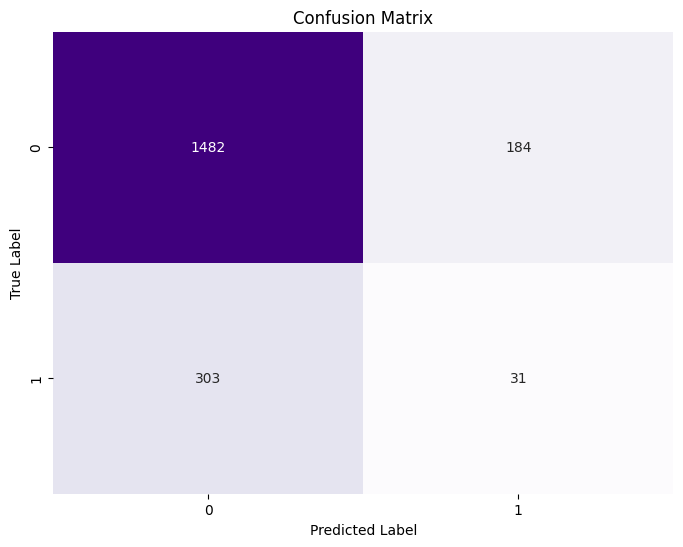

In [172]:
# Example confusion matrix (replace with your actual confusion matrix)
cm = confusion_matrix(y_test,y_pred)

# Create the heatmap
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

## Evaluation metrics review:

### First evaluation:
The evaluation metrics show that the model performed perfectly on test data. As much as this sounds amazing, I know the real world applicability of this is not realistic.

Precision: 100% of predicted positives were correct. No false positives.

Recall: 100% of actual positives of both classes were correct. No false negatives.

F1-Score shows perfect balance of Precision and Recall.

AUC shows a perfect Score (1.0): The model ranks all positive instances (Class 1) higher than all negative instances (Class 0) across all thresholds

This is all a huge red flag and actually made me return the the data set -- lo and behold I accidentally left in opp_ids which were allowing the model to "cheat"

# Update: I removed unique ID and reviewed training and test data. I ran an inspection to see if there was anything else I could to improve the cheating. And there was!
I removed some more columns that had an overdependence on closed won, and my evaluation metrics became less perfect therefore a slightly better model.

Step 7: Use model to provide a probability score for open opps. It might be helpful for an account owner to see the closed won likelihood on their account.

In [144]:
# Filter open opportunities
open_opps = df[df['opportunity_stage'] != 'Closed Won']
X_open = open_opps[features]

# Encode categorical columns as before
X_open_encoded = encoder.transform(X_open[categorical_cols])
X_open_numeric = X_open[numeric_cols].values
X_open_final = np.hstack([X_open_encoded, X_open_numeric])

# Predict probabilities
open_opps['win_probability'] = model.predict_proba(X_open_final)[:, 1]
open_opps[['account', 'win_probability']].head()


,account,win_probability
0,QuantumLabs,0.084851
1,GovTech Innovations,0.159202
2,IndusTech Manufacturing,0.099879
3,Alumitech Manufacturing,0.165691
4,VaultGuardian,0.154217


## Conclusion

This was a good start. My model was predicting if an opp closed won too perfectly, which is indicative of unrealistic data cleanliness. I was not surprised because I did generate this data synthtically using Gretel AI and although it seems random to me, to an ML model there are probably super easy to spot patterns.

I ended up running an inspection of the feature-target relationship to try to remove as many dependencies as possible, and I think this will always be a step in any model I run.

I do like the idea of a simple probability model for business applications. In my experience, when there's a range that's open to interpretation (like cold, warm, hot for example) there's typically a bit of confusion/different opinions.

One thing this project made me think of was how to structure data collection in a way that is conducive to predictive analytics. In Salesforce it's common to have tons of dependent picklists or other values that are highly tied to an outcome. I'm curious the best way to structure the CRM so that data output is set up well for modeling.



### Extra inspection step!

In [136]:
# Step 1: Inspecting Feature-Target Relationship
# Check value counts for categorical features relative to the target
categorical_cols_to_check = ['opportunity_stage_detail','opportunity_category',
                           'opportunity_forecast_category', 'account_vertical',
                           'account_segment', 'lead_source', 'sales_territory']

for col in categorical_cols_to_check:
    print(f"\nRelationship between '{col}' and 'is_won':")
    # Group by the feature and the target, and count occurrences
    print(df.groupby([col, 'is_won']).size().unstack(fill_value=0))
    print("-" * 30)

# For numeric features, you could look at the distribution for each class
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='is_won', y='opportunity_value', data=df)
# plt.title('Distribution of Opportunity Value by Win Status')
# plt.show()


Relationship between 'opportunity_stage_detail' and 'is_won':
is_won                                0    1
opportunity_stage_detail                    
Align on Close Plan                 577    0
Assign Champion                     394    0
Assign Economic Buyer               446    0
Confirm Procurement Steps           504    0
Finalize Contract Terms             540    0
Hand off to CS                        0  840
Identify Champion                   518    0
Identify Competitor                 426    0
Identify Economic Buyer             590    0
Identify Pain                       433    0
Qualify Lead                        532    0
Schedule expansion call internally    0  828
Schedule review call internally     843    0
Solution Alignment                  579    0
Track closed lost reason            810    0
Validate Decision Criteria          567    0
Validate Paper Process and Budget   573    0
------------------------------

Relationship between 'opportunity_category' and 'i